1. Gerekli kütüphaneler

In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

2. Veriyi okuma

In [11]:
# Veriyi oku
train_df = pd.read_csv("../datasets/pca/train_mental_pca.csv")
test_df = pd.read_csv("../datasets/pca/test_mental_pca.csv")

# Özellik ve hedef ayır (✅ doğru hedef sütunu kullanılıyor)
X_train = train_df.drop("support_needed", axis=1)
y_train = train_df["support_needed"]

X_test = test_df.drop("support_needed", axis=1)
y_test = test_df["support_needed"]

print("✅ Eğitim verisi:", X_train.shape)
print("✅ Test verisi:", X_test.shape)
print("🎯 Sınıf dağılımı (y_train):\n", y_train.value_counts())

✅ Eğitim verisi: (1007, 23)
✅ Test verisi: (252, 23)
🎯 Sınıf dağılımı (y_train):
 support_needed
0    528
1    479
Name: count, dtype: int64


In [12]:
# 1. Özellikleri standartlaştır
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. SMOTE ile dengele
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("📊 SMOTE sonrası sınıf dağılımı:", Counter(y_train_balanced))

📊 SMOTE sonrası sınıf dağılımı: Counter({0: 528, 1: 528})


3. ANN Wrapper

In [13]:
# def create_ann_model():
#     model = Sequential()
#     model.add(Input(shape=(X_train.shape[1],)))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))  # binary classification
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [14]:
# ann_model = KerasClassifier(build_fn=create_ann_model, epochs=20, batch_size=32, verbose=0)

4. Diğer modellerin tanımı

In [15]:
svm_model = SVC(probability=True, kernel='linear', random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

5. Voting Classifier

In [16]:
# Voting Classifier (yalnızca sklearn modelleriyle)
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('lr', lr_model),
        ('knn', knn_model),
    ],
    voting='soft'
)

# Eğit
voting_clf.fit(X_train_balanced, y_train_balanced)

VotingClassifier(estimators=[('svm',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

6. Tahmin

In [17]:
# Tahmin
y_pred = voting_clf.predict(X_test_scaled)
y_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

7. Değerlendirme

📋 Sınıflandırma Raporu (Voting Classifier):

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       132
           1       0.79      0.83      0.81       120

    accuracy                           0.82       252
   macro avg       0.82      0.82      0.82       252
weighted avg       0.82      0.82      0.82       252



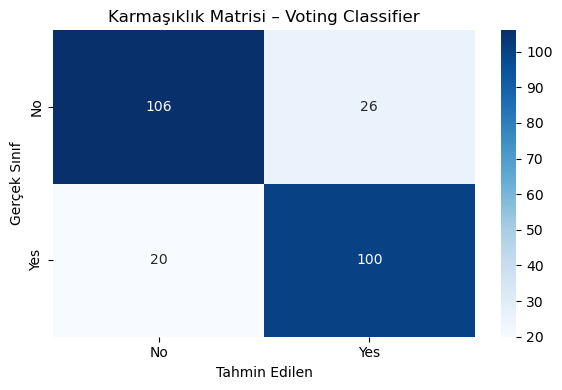

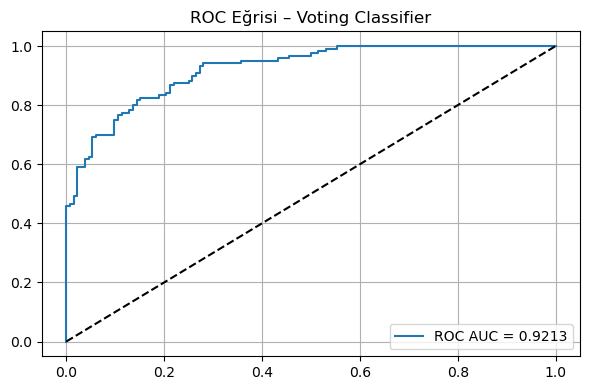

In [18]:
# Rapor
print("📋 Sınıflandırma Raporu (Voting Classifier):\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – Voting Classifier")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrisi – Voting Classifier")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()